In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\L.RAMYA\Downloads\AirPassengers.csv")
df

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121
...,...,...
139,15-08-1960,606
140,15-09-1960,508
141,15-10-1960,461
142,15-11-1960,390


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df = df.set_index('Month')
df

,Passengers
Month,
15-01-1949,112
15-02-1949,118
15-03-1949,132
15-04-1949,129
15-05-1949,121
...,...
15-08-1960,606
15-09-1960,508
15-10-1960,461


# Visualize the time series
**check for trend,seasonality or random patterns**

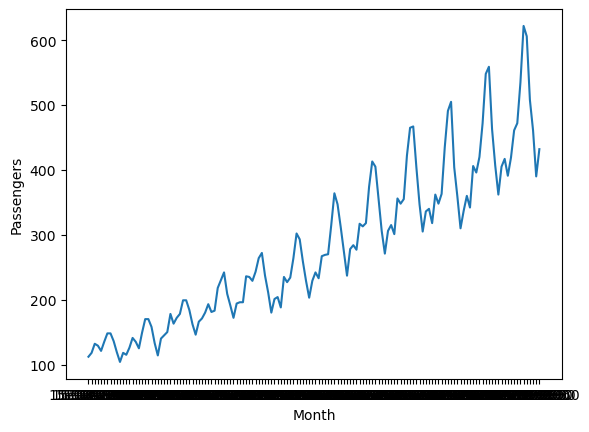

In [5]:
sns.lineplot(x=df.index,y=df['Passengers'])
plt.show()

**uptrend sales  and seasonal why means the plot is increasing,month wise the passengers are increasing and decreasing**

# check for staionarity

**method-1 : Rolling statistics**

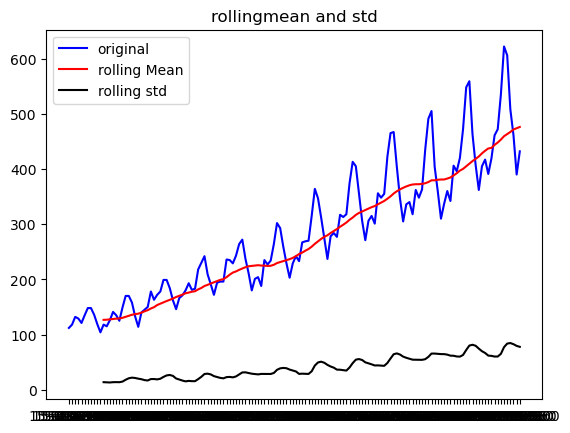

In [6]:
# determing rolling statistics
rolmean = df['Passengers'].rolling(window=12).mean()#here months so we can take window=12
rolstd = df['Passengers'].rolling(window=12).std()

#plot rolling statistics:
orig = plt.plot(df['Passengers'],color='blue',label='original')
mean = plt.plot(rolmean,color='red',label='rolling Mean')
std = plt.plot(rolstd,color='black',label='rolling std')
plt.title('rollingmean and std')
plt.xticks(ticks=df.index)
plt.legend()
plt.show()

**# method 2 augmented dicky fuller test**
- for the ADF test
- h0:data is non-stationary
- h1:data is stationary
- based on pvalue ,we will accept or reject h0 (if p-value<5%reject null hypothesis)

In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(df['Passengers'])
adfuller_result

(0.8153688792060547,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:
print('p-value:',adfuller_result[1])

p-value: 0.9918802434376411


**the time series is non-stationary**

# now ,we have to convert the non-stationary data to stationary data

In [9]:
# apply differencing
diff = df['Passengers']-df['Passengers'].shift(1)
diff

diff.dropna(inplace=True)

adfuller_result = adfuller(diff)
print('p-value of adf test:',adfuller_result[1])

p-value of adf test: 0.05421329028382491


In [10]:
# apply differencing
diff = df['Passengers']-df['Passengers'].shift(2)
diff

diff.dropna(inplace=True)

adfuller_result = adfuller(diff)
print('p-value of adf test:',adfuller_result[1])

p-value of adf test: 0.03862975767698775


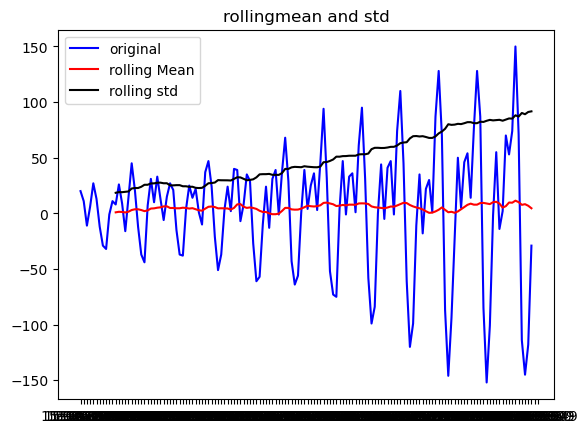

In [11]:
# determing rolling statistics
rolmean = diff.rolling(window=12).mean()#here months so we can take window=12
rolstd = diff.rolling(window=12).std()

#plot rolling statistics:
orig = plt.plot(diff,color='blue',label='original')
mean = plt.plot(rolmean,color='red',label='rolling Mean')
std = plt.plot(rolstd,color='black',label='rolling std')
plt.title('rollingmean and std')
plt.xticks(ticks=df.index)
plt.legend()
plt.show()

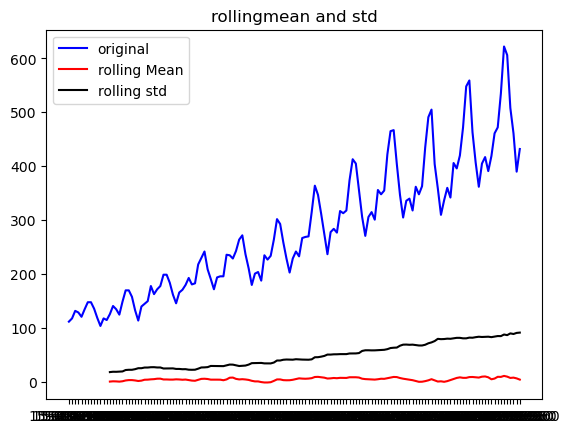

In [12]:
# determing rolling statistics
rolmean = diff.rolling(window=12).mean()#here months so we can take window=12
rolstd = diff.rolling(window=12).std()

#plot rolling statistics:
orig = plt.plot(df['Passengers'],color='blue',label='original')
mean = plt.plot(rolmean,color='red',label='rolling Mean')
std = plt.plot(rolstd,color='black',label='rolling std')
plt.title('rollingmean and std')
plt.xticks(ticks=df.index)
plt.legend()
plt.show()

# train-test split
**split the data into train(80%) and test(20%)**
- for timeseries data,we have use first 80% of records for training and next 20% of records for testing
- here 80%=0.8*142=114 records,so first 114 records we have to use for training

- **note : we should not apply train-test split function ,because it divides the data randomly**

In [13]:
y_train = diff[:114]
y_test = diff[114:]

# Build ARIMA model
** ARIMA model is build by using p,d,q values**
- p is AR value(determined from PACF plot)
- d is intergration
- q is MA value(determined from ACF plot)

- **plot ACF/PACF and find np p and q parameters**
- auto correlation function - a function which gives us values of auto -correction of any series
with its lagged values
- Partial auto correlation function(PACF)- An indirect function to find Auto correlation after removing
    the relationship explained by previous lags

**time series lag example**
- original time series = {21,22,21,20,19}
- lagged time series by 1 lag ={22,21,20,19}
- lag 1 correlation will be correlation between {21,22,21,20,19}and{22,21,20,19}

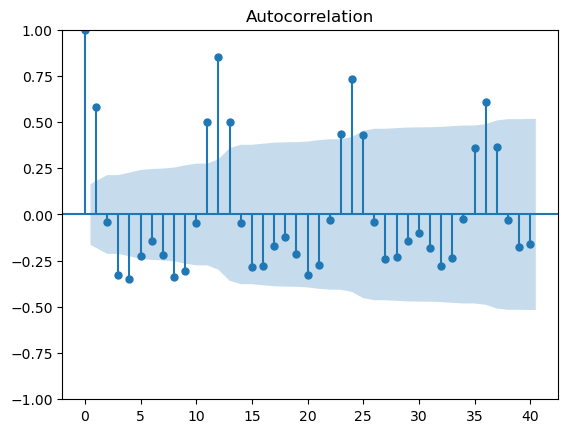

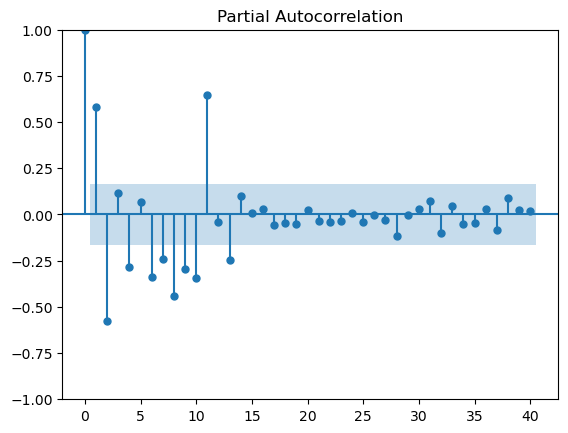

In [14]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig = sm.graphics.tsa.plot_acf(diff,lags=40)
fig = sm.graphics.tsa.plot_pacf(diff,lags=40)

In [15]:
import warnings 
warnings.filterwarnings('ignore')


In [16]:
# modelling 
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA (diff,order=(11,0,0))
ARIMA = model.fit()

# prediction
y_pred_train = ARIMA.predict(start=y_train.index[0],end=y_train.index[-1])
y_pred_test =ARIMA.predict(start=y_test.index[0],end=y_test.index[-1])

# evaluation
from sklearn.metrics import r2_score
print('Train R2 of ARIMA model:',r2_score(y_pred_train,y_train))
print('Train R2 of ARIMA model:',r2_score(y_pred_test,y_test))


Train R2 of ARIMA model: 0.9354945375501107
Train R2 of ARIMA model: 0.9551178155890222


In [17]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA (diff,order=(11,0,12))
ARIMA = model.fit()

# prediction
y_pred_train = ARIMA.predict(start=y_train.index[0],end=y_train.index[-1])
y_pred_test =ARIMA.predict(start=y_test.index[0],end=y_test.index[-1])

# evaluation
from sklearn.metrics import r2_score
print('Train R2 of ARIMA model:',r2_score(y_pred_train,y_train))
print('Train R2 of ARIMA model:',r2_score(y_pred_test,y_test))


Train R2 of ARIMA model: 0.9381755050782792
Train R2 of ARIMA model: 0.9658019602147241


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX (diff,seasonal_order=(11,1,12,12))
SARIMAX = model.fit()

# prediction
y_pred_train = SARIMAX.predict(start=y_train.index[0],end=y_train.index[-1])
y_pred_test = SARIMAX.predict(start=y_test.index[0],end=y_test.index[-1])

# evaluation
from sklearn.metrics import r2_score
print('Train R2 of ARIMA model:',r2_score(y_pred_train,y_train))
print('Train R2 of ARIMA model:',r2_score(y_pred_test,y_test))


Train R2 of ARIMA model: 0.9021355428038431
Train R2 of ARIMA model: 0.9562824199420396
